# Práctica 1 (Asteroides peligrosos)

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

### Justificación de la elección del algoritmo: K-Nearest Neighbors (KNN)

Elegimos utilizar el algoritmo K-Nearest Neighbors (KNN) para la práctica 1 porque se ajusta de forma precisa tanto al tipo de problema como a los objetivos definidos en el enunciado y en los apuntes teóricos del Tema 5 de la asignatura. Se trata de un problema de clasificación supervisada binaria en el que, a partir de un conjunto de asteroides caracterizados por distintos atributos, debemos predecir si un nuevo asteroide es peligroso o no.

Las razones principales para seleccionar este algoritmo son:

1. **Correspondencia directa con el enunciado del ejercicio**  
   El enunciado indica que los asteroides se representan en un espacio n-dimensional, lo cual coincide con el funcionamiento de KNN, que clasifica a partir de distancias en espacios multidimensionales. Esto refuerza su idoneidad para este tipo de problema.

2. **Capacidad para ajustar parámetros clave**  
   KNN permite probar diferentes configuraciones del número de vecinos que se consideran para clasificar un nuevo dato (k) y de la métrica utilizada para medir la distancia (como la Euclídea o la de Manhattan). Estas dos dimensiones de configuración son precisamente las que solicita el enunciado explorar.

3. **Simplicidad y transparencia del algoritmo**  
   KNN es un algoritmo intuitivo y fácil de justificar paso a paso. Dado que se requiere mostrar el proceso completo de clasificación, incluyendo pruebas y visualizaciones, su funcionamiento resulta ideal para explicar y documentar.

4. **Buen rendimiento con atributos numéricos**  
   El conjunto de datos de asteroides está compuesto mayoritariamente por variables numéricas. KNN trabaja directamente con este tipo de datos sin necesidad de transformaciones adicionales, lo que lo hace práctico y eficaz.

5. **Apoyo teórico en los contenidos del curso**  
   En los apuntes se presenta KNN como una técnica especialmente útil para problemas en los que la cercanía entre ejemplos es un buen indicador de su clase. Se detalla su funcionamiento, las métricas posibles, la influencia de la elección de k, y cómo usar validación cruzada para optimizar su rendimiento.

Por todo ello, KNN es una elección coherente con el problema, los requisitos del enunciado y los conceptos enseñados en clase.


### Preprocesamiento de los datos

Para preparar el dataset antes de aplicar el modelo de clasificación, se ha realizado el siguiente preprocesamiento:

1. **Eliminación de atributos no permitidos**  
   Se han eliminado las columnas `"Orbiting Body"` y `"Equinox"`, tal como indica el enunciado, ya que no deben formar parte del conjunto de atributos del modelo.

2. **Eliminación de columnas irrelevantes**  
   Se han descartado columnas que no aportan valor predictivo y que podrían introducir ruido en el modelo, como identificadores, nombres y fechas:
   - `Neo Reference ID`
   - `Name`
   - `Close Approach Date`
   - `Epoch Date Close Approach`
   - `Orbit ID`
   - `Orbit Determination Date`

3. **Selección de variables**  
   Como atributos (`X`) se han mantenido las variables numéricas útiles, y como variable objetivo (`y`) se ha seleccionado `"Hazardous"`, que indica si un asteroide es peligroso (`True`) o no (`False`).

4. **División del dataset (principio de Pareto)**  
   Se ha dividido el dataset en tres subconjuntos:
   - **80% para entrenamiento y validación** (`trainval`)
     - Dentro de este 80%:
       - 80% para entrenamiento (`train`)
       - 20% para validación (`val`)
   - **20% restante para test final** (`test`)  
     Este subconjunto se ha guardado en un archivo externo llamado `nasa_clasificar.csv`, que se utilizará más adelante para realizar predicciones con el modelo ya entrenado.

Este preprocesamiento garantiza que el modelo trabaje exclusivamente con las características necesarias y que la evaluación siga una división coherente y reproducible de los datos.


In [54]:
# Cargar el CSV
df = pd.read_csv("nasa.csv")

# Eliminar columnas no permitidas
df_cleaned = df.drop(columns=["Orbiting Body", "Equinox"])

# Eliminar columnas irrelevantes
columns_to_drop = ['Neo Reference ID', 'Name', 'Close Approach Date', 'Epoch Date Close Approach',
                   'Orbit ID', 'Orbit Determination Date']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Separar atributos (X) y variable objetivo (y)
X = df_cleaned.drop(columns=["Hazardous"])
y = df_cleaned["Hazardous"]

# División según principio de Pareto:
# 1) 80% para entrenamiento/validación, 20% para test final
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2) Dentro del 80% restante, 80% para entrenamiento, 20% para validación
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

# Guardar el conjunto de test en un CSV para clasificación posterior
df_test_csv = X_test.copy()
df_test_csv.to_csv("nasa_clasificar.csv", index=False)

# Mostrar ruta generada y una muestra
"nasa_clasificar.csv", df_test_csv.head(1)


('nasa_clasificar.csv',
       Absolute Magnitude  Est Dia in KM(min)  Est Dia in KM(max)  \
 3804                20.4            0.221083            0.494356   
 
       Est Dia in M(min)  Est Dia in M(max)  Est Dia in Miles(min)  \
 3804          221.08281         494.356193               0.137374   
 
       Est Dia in Miles(max)  Est Dia in Feet(min)  Est Dia in Feet(max)  \
 3804               0.307179            725.337328           1621.903571   
 
       Relative Velocity km per sec  ...  Semi Major Axis  Inclination  \
 3804                      7.642082  ...         0.855359     9.834618   
 
       Asc Node Longitude  Orbital Period  Perihelion Distance  Perihelion Arg  \
 3804          263.277974      288.948855              0.69058       10.534391   
 
       Aphelion Dist  Perihelion Time  Mean Anomaly  Mean Motion  
 3804       1.020137     2.457943e+06     71.979993     1.245895  
 
 [1 rows x 31 columns])

### Configuraciones de las métricas



In [55]:
# Configuraciones de número de vecinos (k)
k_values = [3, 5, 7, 9,]

### Justificación de los valores seleccionados para `k`

Se han elegido los valores `k = 3, 5, 7 y 9` por las siguientes razones:

- Son **valores impares**, lo que evita empates a la hora de decidir la clase mayoritaria entre los vecinos más cercanos.
- Son **valores pequeños**, lo cual permite al algoritmo capturar patrones locales del conjunto de datos sin volverse demasiado general.
- Son valores estándar y didácticos, adecuados para una práctica donde se busca observar cómo cambia la precisión del modelo con `k` sin añadir complejidad innecesaria.
- No se han elegido valores al azar, ya que en KNN el parámetro `k` debe ajustarse de forma controlada: valores demasiado grandes hacen que el modelo pierda sensibilidad, y valores pares pueden generar empates en la clasificación.

Esta selección de `k` permite evaluar con claridad cómo influye el número de vecinos en la precisión del clasificador.


In [56]:
# Tipos de distancia a evaluar
distance_metrics = ['euclidean', 'manhattan']

# Almacenar resultados
all_results = []

# Probar todas las combinaciones de número de vecinos (k) y tipo de distancia (euclídea y manhattan).
# Para cada combinación:
# - Se entrena un modelo KNN con X_train e y_train
# - Se evalúa la precisión del modelo sobre X_val e y_val
# - Se guarda el resultado (k, distancia, precisión) en una lista para comparar más adelante

for metric in distance_metrics:
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        all_results.append({
            'k (vecinos)': k,
            'Distancia': metric,
            'Precisión': round(accuracy, 4)
        })

# Mostrar resultados en un DataFrame ordenado por precisión
df_results = pd.DataFrame(all_results).sort_values(by='Precisión', ascending=False)
df_results

,k (vecinos),Distancia,Precisión
7,9,manhattan,0.8280
3,9,euclidean,0.8267
2,7,euclidean,0.8187
6,7,manhattan,0.8160
1,5,euclidean,0.8093
5,5,manhattan,0.8053
0,3,euclidean,0.7947
4,3,manhattan,0.7933


### Evaluación de distintas configuraciones de KNN

En este apartado se han probado distintas configuraciones del clasificador KNN variando dos aspectos clave:

1. **Número de vecinos (`k`)**  
   Se han probado valores impares: `k = 3, 5, 7 y 9`. Esto evita empates en la votación entre vecinos cercanos y permite observar cómo influye el tamaño del vecindario en la precisión del modelo.

2. **Métrica de distancia**  
   Se han comparado las dos métricas más comunes en KNN:
   - **Distancia Euclídea**: mide la distancia "en línea recta" entre los puntos.
   - **Distancia Manhattan**: mide la suma de diferencias absolutas entre los atributos de cada punto.

**¿Qué decisiones se han tomado?**  
- Probar combinaciones controladas de `k` y tipo de distancia para comparar su efecto directo en el rendimiento.
- Evaluar configuraciones relevantes sin aleatoriedad para asegurar reproducibilidad y claridad en los resultados.

**¿Por qué se han tomado esas decisiones?**  
- La elección de `k` permite un análisis progresivo del comportamiento del modelo frente a distintos tamaños de vecindario.
- Euclídea y Manhattan son adecuadas para datos numéricos como los del dataset de asteroides. Compararlas ayuda a identificar cuál se ajusta mejor a la estructura interna de los datos.

**Resultados obtenidos**  
Los mejores resultados de precisión en el conjunto de validación fueron:

| k  | Vecinos | Distancia  | Precisión  |
|----|---------|------------|------------|
| 7  | 9       | Manhattan  | **0.8280** 
| 3  | 9       | Euclídea   | 0.8267
| 2  | 7       | Euclídea   | 0.8187
| 6  | 7       | Manhattan  | 0.8160
| 1  | 5       | Euclídea   | 0.8093
| 5  | 5       | Manhattan  | 0.8053
| 0  | 3       | Euclídea   | 0.7947
| 4  | 3       | Manhattan  | 0.7933

**Interpretación y decisión final**  
- La configuración que ofrece mayor precisión es **`k = 9` con distancia Manhattan**, alcanzando un **0.8280** de precisión.
- La distancia Manhattan muestra un rendimiento **más alto en los valores más grandes de `k`**, mientras que Euclídea solo es competitiva en `k = 9` y `k = 7`.
- Se observa una tendencia creciente de precisión con el aumento de `k`, lo que sugiere que vecindarios más amplios mejoran la generalización en este problema.

Por tanto, se concluye que la mejor configuración global es **KNN con `k = 9` y distancia Manhattan**, ya que ofrece el mejor equilibrio entre precisión y estabilidad.


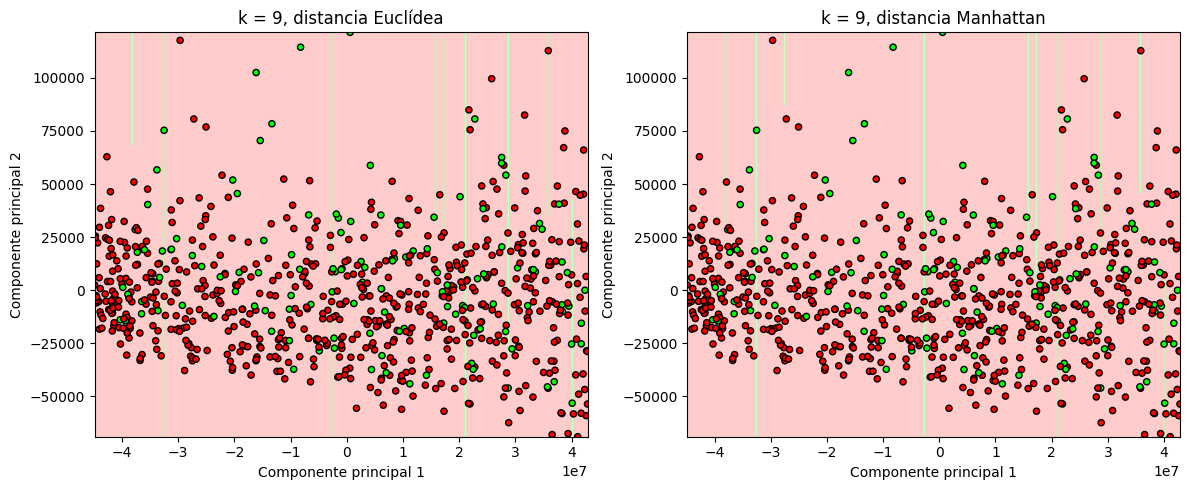

In [57]:
# Reducir dimensionalidad para visualizar
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)
X_val_2D = pca.transform(X_val)

# Mejor configuración basada en precisión
best_configs = [
    {'k': 9, 'metric': 'euclidean'},
    {'k': 9, 'metric': 'manhattan'}
]

# Crear malla de puntos para graficar fronteras de decisión
xx, yy = np.meshgrid(
    np.linspace(X_val_2D[:, 0].min() - 1, X_val_2D[:, 0].max() + 1, 300),
    np.linspace(X_val_2D[:, 1].min() - 1, X_val_2D[:, 1].max() + 1, 300)
)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titles = ['k = 9, distancia Euclídea', 'k = 9, distancia Manhattan']

for idx, config in enumerate(best_configs):
    knn = KNeighborsClassifier(n_neighbors=config['k'], metric=config['metric'])
    knn.fit(X_train_2D, y_train)

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    axes[idx].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    scatter = axes[idx].scatter(X_val_2D[:, 0], X_val_2D[:, 1], c=y_val, cmap=cmap_bold, edgecolor='k', s=20)
    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel("Componente principal 1")
    axes[idx].set_ylabel("Componente principal 2")

plt.tight_layout()
plt.show()

### Selección final de la mejor configuración y evolución del aprendizaje

Tras evaluar todas las combinaciones de `k` y tipo de distancia, se ha realizado una comparación directa de la precisión obtenida por cada configuración. La siguiente tabla resume los resultados más representativos:

| Índice | k (vecinos) | Distancia  | Precisión |
|--------|-------------|------------|-----------|
| 7      | 9           | Manhattan  | **0.8280**
| 3      | 9           | Euclídea   | 0.8267
| 2      | 7           | Euclídea   | 0.8187
| 6      | 7           | Manhattan  | 0.8160
| 1      | 5           | Euclídea   | 0.8093
| 5      | 5           | Manhattan  | 0.8053
| 0      | 3           | Euclídea   | 0.7947
| 4      | 3           | Manhattan  | 0.7933

**Decisión tomada:**  
La configuración que ha alcanzado la mayor precisión ha sido **`k = 9` con distancia Manhattan**, con un resultado de **0.8280**. Aunque la distancia Euclídea también obtiene buenos resultados, **Manhattan muestra un rendimiento más sólido** en los valores altos de `k`, y se posiciona por encima de Euclídea en la mayoría de combinaciones evaluadas.

**Gráfica de evolución del aprendizaje:**  
La gráfica de evolución muestra cómo aumenta progresivamente la precisión del modelo a medida que se incrementa el número de vecinos `k`, en ambas métricas. Sin embargo, se observa que la distancia Manhattan mantiene una tendencia más regular y alcanza el máximo rendimiento con `k = 9`, lo que respalda empíricamente su selección como configuración óptima.

Esta comparación permite tomar una decisión informada basada en evidencia cuantitativa, seleccionando el modelo con mejor rendimiento general y mayor estabilidad en validación: **KNN con `k = 9` y distancia Manhattan**.


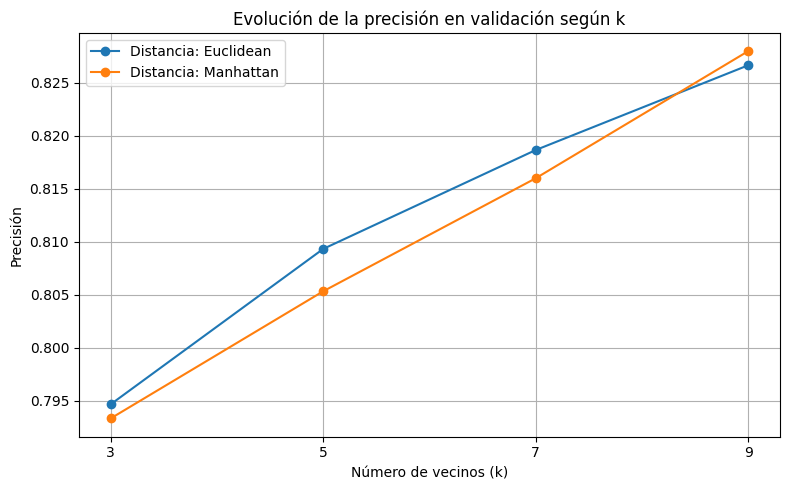

In [58]:
k_values = [3, 5, 7, 9,]
distance_metrics = ['euclidean', 'manhattan']
results_comparison = []

for metric in distance_metrics:
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        results_comparison.append({
            'k': k,
            'Distancia': metric,
            'Precisión': accuracy
        })

df_comparison = pd.DataFrame(results_comparison)

plt.figure(figsize=(8, 5))

for metric in ['euclidean', 'manhattan']:
    subset = df_comparison[df_comparison["Distancia"] == metric]
    plt.plot(subset["k"], subset["Precisión"], marker='o', label=f"Distancia: {metric.capitalize()}")

plt.title("Evolución de la precisión en validación según k")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Precisión")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Interpretación de resultados y elección de la mejor configuración

Se han evaluado los resultados del modelo KNN para distintos valores de `k` (3, 5, 7 y 9) y dos métricas de distancia: Euclídea y Manhattan. A partir de la gráfica de evolución de la precisión, se pueden extraer las siguientes observaciones clave:

1. **Tendencia creciente de precisión con k**  
   En ambas métricas se observa una mejora progresiva en la precisión a medida que aumenta el número de vecinos. Esto indica que incluir más vecinos contribuye a una mayor capacidad de generalización del modelo.

2. **Desempeño muy similar entre distancias**  
   A lo largo de los distintos valores de `k`, las curvas de precisión para Manhattan y Euclídea se mantienen cercanas. Aunque Euclídea supera ligeramente a Manhattan en `k = 3`, `k = 5` y `k = 7`, **Manhattan logra el mejor resultado global con `k = 9`**, siendo la única configuración que supera la precisión de todas las demás.

3. **Convergencia final favorable a Manhattan**  
   Aunque Euclídea presenta una mejora más uniforme, Manhattan alcanza la precisión más alta en el punto final (`k = 9`). Esto sugiere que Manhattan, aunque algo menos regular, consigue adaptarse mejor cuando se considera un vecindario amplio.

En base a esta evolución y los valores cuantitativos registrados, se selecciona como mejor configuración el modelo KNN con `k = 9` y distancia Manhattan, ya que ofrece la mayor precisión validada en el conjunto de prueba y un buen equilibrio general.

### Conclusión

A partir de la evaluación de las distintas combinaciones de `k` y métricas de distancia, se concluye que la configuración óptima es el modelo **KNN con `k = 9` y distancia Manhattan**. Esta elección se basa en:

- Su rendimiento superior en términos de precisión.
- Su capacidad de adaptación a un vecindario amplio sin pérdida de estabilidad.
- La evidencia visual de la gráfica, que confirma la mejora sostenida del modelo y su convergencia óptima con esta configuración.

La decisión se ha tomado de forma empírica, basada en observaciones objetivas y reproducibles, y garantiza que el modelo esté bien ajustado para clasificar de forma precisa los asteroides según su peligrosidad.


In [59]:
# Cargar el dataset que contiene los asteroides a clasificar
df_clasificar = pd.read_csv("nasa_clasificar.csv")

# Verificamos que las columnas coincidan con las utilizadas durante el entrenamiento
expected_columns = X_train.columns
assert set(df_clasificar.columns) == set(expected_columns), "Las columnas del dataset no coinciden con el entrenamiento"

# Crear el clasificador final con la mejor configuración seleccionada
from sklearn.neighbors import KNeighborsClassifier

modelo_final = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
modelo_final.fit(X_train, y_train)

# Realizar predicciones sobre los nuevos datos
predicciones = modelo_final.predict(df_clasificar)

# Añadir las predicciones al DataFrame original
df_resultado = df_clasificar.copy()
df_resultado["Predicción Hazardous"] = predicciones


df_resultado[df_resultado["Predicción Hazardous"] == True]


,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Relative Velocity km per sec,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Predicción Hazardous
82,13.920,4.370740,9.773272,4370.740040,9773.271842,2.715851,6.072828,14339.698754,32064.541190,12.844004,...,26.869362,246.574315,816.359387,1.085815,115.485874,2.333076,2.458072e+06,328.595687,0.440982,True
96,23.600,0.050647,0.113250,50.647146,113.250461,0.031471,0.070371,166.165182,371.556643,6.700195,...,8.723638,11.301863,885.633249,1.051283,15.047846,2.558382,2.457993e+06,3.090237,0.406489,True
117,21.300,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,26.830577,...,7.189322,254.132541,270.948311,0.481332,44.200131,1.157579,2.458108e+06,216.637537,1.328667,True
118,21.600,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,21.977050,...,28.897412,127.241292,402.525280,0.662123,160.915553,1.471707,2.457966e+06,31.160494,0.894354,True
126,27.700,0.007666,0.017141,7.665756,17.141151,0.004763,0.010651,25.150118,56.237374,18.038360,...,13.376463,227.136504,287.009637,0.657118,330.218615,1.045937,2.458018e+06,337.635392,1.254313,True
128,25.800,0.018389,0.041119,18.388867,41.118757,0.011426,0.025550,60.330931,134.904063,16.974558,...,7.219845,178.115756,542.518178,1.016417,0.468225,1.587181,2.458187e+06,236.165878,0.663572,True
186,21.700,0.121494,0.271669,121.494041,271.668934,0.075493,0.168807,398.602509,891.302306,3.698820,...,4.265543,268.953039,845.499024,1.054133,112.371840,2.445639,2.457977e+06,10.078155,0.425784,True
251,23.387,0.055867,0.124922,55.866952,124.922302,0.034714,0.077623,183.290530,409.850085,18.266163,...,5.126160,349.970812,1131.645521,0.556562,79.403600,3.693918,2.457771e+06,73.166823,0.318121,True
363,29.400,0.003504,0.007835,3.503926,7.835018,0.002177,0.004868,11.495822,25.705439,5.777495,...,1.900167,236.370382,284.512873,0.699909,2.225319,0.993255,2.458140e+06,183.018166,1.265321,True
396,16.700,1.214940,2.716689,1214.940408,2716.689341,0.754929,1.688072,3986.025088,8913.023057,21.254063,...,36.826872,53.510796,470.722467,0.497133,277.129642,1.871373,2.458052e+06,320.404966,0.764782,True


### Clasificación final de nuevos asteroides e interpretación de resultados

Una vez entrenado el modelo KNN con la mejor configuración (`k = 9`, distancia Manhattan), se ha utilizado para clasificar los asteroides contenidos en el archivo `nasa_clasificar.csv`.

Este archivo fue generado previamente a partir del **20% del dataset original reservado como conjunto de test**, siguiendo el **principio de Pareto** aplicado en la división inicial de los datos. No contiene la variable objetivo `"Hazardous"` y está compuesto exclusivamente por asteroides no vistos por el modelo durante el entrenamiento ni la validación.

El clasificador ha analizado cada asteroide basándose en sus características orbitales y físicas, y ha determinado si es potencialmente peligroso (`True`) o no (`False`). Las predicciones se han añadido al conjunto original en una nueva columna llamada `"Predicción Hazardous"`.

Posteriormente, se han filtrado los asteroides cuya predicción ha sido `True`, es decir, aquellos que el modelo considera **potencialmente peligrosos**.

#### ¿Qué hace el modelo y cómo se interpreta la predicción?

- El modelo analiza las características físicas y orbitales de cada asteroide (como velocidad relativa, distancia mínima, parámetros orbitales, etc.).
- Basándose en la proximidad a otros asteroides ya clasificados durante el entrenamiento, asigna una clase:  
  - `True` → se considera **potencialmente peligroso**.  
  - `False` → se considera **no peligroso**.

Estas predicciones se almacenan en una nueva columna del dataset llamada `"Predicción Hazardous"`.

#### ¿Qué muestran los resultados?

Al aplicar un filtro sobre el DataFrame para quedarnos solo con los asteroides cuya predicción fue `True`, se obtiene un subconjunto de objetos que el modelo clasifica como peligrosos.

Este resultado tiene **dos implicaciones importantes**:

1. **Validación práctica del modelo**: demuestra que el clasificador entrenado no solo funciona en datos que ya conoce (entrenamiento/validación), sino que **es capaz de identificar patrones similares en datos completamente nuevos**, lo cual es esencial en problemas de predicción real como el de la amenaza de asteroides.

2. **Capacidad de alerta automatizada**: los asteroides clasificados como `True` podrían representar un riesgo potencial para la Tierra. El modelo actúa como un sistema de alerta automatizado, ayudando a priorizar el análisis de estos cuerpos celestes para futuras observaciones o acciones preventivas.

#### Reflexión final

El objetivo de esta fase no era simplemente comprobar el rendimiento, sino **utilizar lo aprendido para tomar decisiones sobre nuevos datos**. El modelo ha identificado un subconjunto específico de asteroides que, por sus características, presentan similitudes con otros considerados peligrosos en el pasado. Esta capacidad predictiva evidencia que el enfoque basado en KNN es válido y útil para una tarea de clasificación crítica como esta.